In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#from pandas_profiling import ProfileReportofileReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate,true_positive_rate,count


from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from xgboost import XGBRegressor,XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from tqdm.notebook import tqdm
from collections import defaultdict 

In [3]:
df = pd.read_csv("data/so2019.csv")


In [4]:
# Convert the target
df["Score"] = df["convertedcomp"]

df.loc[df["convertedcomp"] >  df.convertedcomp.median(), "Score"] = 1
df.loc[df["convertedcomp"] <= df.convertedcomp.median(), "Score"] = 0

# Data cleaning
df.yearscode = df.yearscode.replace('Less than 1 year',1)
df.yearscode = df.yearscode.replace('More than 50 years',50)
df.yearscode = df.yearscode.replace(np.nan,0)
df.yearscode= df.yearscode.astype(int)
df = df.fillna(df.mean())

In [5]:

X = df.drop(columns=['convertedcomp','Score'])
y = df[["Score"]]

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [7]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = "", min_samples: int = 500):

    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].value_counts()
    cats = cats[cats > min_samples].index.tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        elif cat == "all":
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))
        else:
            pass

    return dicc

  0%|          | 0/20 [00:00<?, ?it/s]

Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow
Found 143 subgroups. Evaluation may be slow


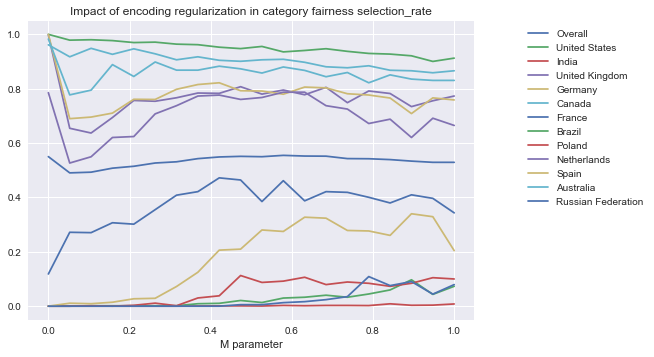

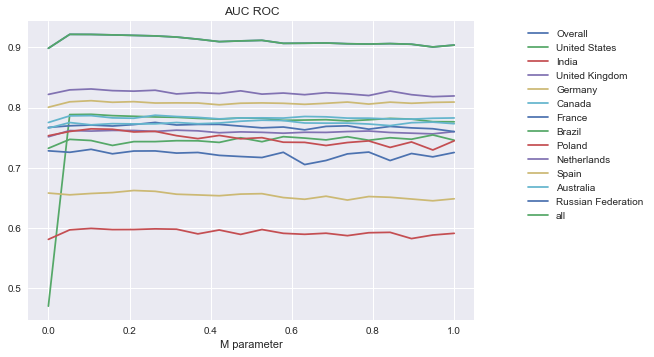

  0%|          | 0/20 [00:00<?, ?it/s]

Found 143 subgroups. Evaluation may be slow


TypeError: '<' not supported between instances of 'int' and 'NoneType'

In [8]:
for metrics in [selection_rate, false_positive_rate, true_positive_rate]:
    MIN_SAMPLES=499
    gms = []
    gms_rec = []
    ms = []
    auc = {}

    #param = [0, 1,2, 5, 10, 20, 50, 100]
    param = np.linspace(0,1,20)
    for m in tqdm(param):
        encoder = MEstimateEncoder(m=m)
        #encoder = TargetEncoder(smoothing=m)
        encoder = LeaveOneOutEncoder(sigma=m)
        
        #model = LogisticRegression()
        model = GradientBoostingClassifier()

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_te)

        gm = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["country"],
        )
        auc = auc_group(
            model=pipe, data=X_te, y_true=y_te, dicc=auc, group="country",min_samples=MIN_SAMPLES
        )
        
        gms.append(gm)
        ms.append(m)



    # Ethnic
    plt.figure()
    title = "Impact of encoding regularization in category fairness " + str(
        metrics.__name__
    )
    plt.title(title)
    plt.xlabel("M parameter")
    plt.plot(ms, [gm.overall for gm in gms], label="Overall")
    

    for element in auc.keys():
        try:
            plt.plot(ms, [gm.by_group[element] for gm in gms], label=element)
        except:
            pass

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

    # AUC ROC
    plt.title("AUC ROC")
    plt.xlabel("M parameter")
    plt.plot(ms, auc["all"], label="Overall")
    for element in auc.keys():
        plt.plot(ms, auc[element], label=element)

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

In [ ]:
auc